In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc

2023-08-23 14:13:43.736084: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 14:13:43.764136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 14:13:44.355572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mediapipe.__version__)

TensorFlow v2.13.0
Mediapipe v0.10.3


In [3]:
gpu = tf.config.experimental.list_physical_devices('GPU')
gpu

2023-08-23 14:13:47.257434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 14:13:47.261055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 14:13:47.261154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
dataset_df = pd.read_csv('train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (67208, 5)


In [5]:
dataset_df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [6]:
# # Fetch sequence_id, file_id, phrase from first row
# sequence_id, file_id, phrase = dataset_df.iloc[0][['sequence_id', 'file_id', 'phrase']]
# print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")

In [7]:
# # Fetch data from parquet file
# # sample_sequence_df = pq.read_table(f"train_landmarks/{str(file_id)}.parquet",
# #     filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()

# # print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))
# file_path = 'train_landmarks/{}.parquet'.format(str(file_id))

# data = pd.read_parquet(file_path)
# print(data.index.unique())

In [8]:
# data.head()

In [9]:
# data_seq = data.loc[sequence_id]
# data_seq.shape

In [10]:
# data_seq.head()

The hand landmark positions for ***3 creekhouse***

In [11]:
# # Function create animation from images.

# matplotlib.rcParams['animation.embed_limit'] = 2**128
# matplotlib.rcParams['savefig.pad_inches'] = 0
# rc('animation', html='jshtml')

# def create_animation(images):
#     fig = plt.figure(figsize=(6, 9))
#     ax = plt.Axes(fig, [0., 0., 1., 1.])
#     ax.set_axis_off()
#     fig.add_axes(ax)
#     im=ax.imshow(images[0], cmap="gray")
#     plt.close(fig)
    
#     def animate_func(i):
#         im.set_array(images[i])
#         return [im]

#     return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

In [12]:
# # Extract the landmark data and convert it to an image using medipipe library.
# # This function extracts the data for both hands.

# mp_pose = mediapipe.solutions.pose
# mp_hands = mediapipe.solutions.hands
# mp_drawing = mediapipe.solutions.drawing_utils 
# mp_drawing_styles = mediapipe.solutions.drawing_styles

# def get_hands(seq_df):
#     images = []
#     all_hand_landmarks = []
#     for seq_idx in range(len(seq_df)):
#         x_hand = seq_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
#         y_hand = seq_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
#         z_hand = seq_df.iloc[seq_idx].filter(regex="z_right_hand.*").values

#         right_hand_image = np.zeros((600, 600, 3))  # why 600? may be just to create a square frame with 600 black pixels?

#         right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        
#         for x, y, z in zip(x_hand, y_hand, z_hand):
#             right_hand_landmarks.landmark.add(x=x, y=y, z=z)

#         mp_drawing.draw_landmarks(
#                 right_hand_image,
#                 right_hand_landmarks,
#                 mp_hands.HAND_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
#         x_hand = seq_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
#         y_hand = seq_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
#         z_hand = seq_df.iloc[seq_idx].filter(regex="z_left_hand.*").values
        
#         left_hand_image = np.zeros((600, 600, 3))
        
#         left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
#         for x, y, z in zip(x_hand, y_hand, z_hand):
#             left_hand_landmarks.landmark.add(x=x, y=y, z=z)

#         mp_drawing.draw_landmarks(
#                 left_hand_image,
#                 left_hand_landmarks,
#                 mp_hands.HAND_CONNECTIONS,
#                 landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
#         images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
#         all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])
#     return images, all_hand_landmarks

In [13]:
# # Get the images created using mediapipe apis
# hand_images, hand_landmarks = get_hands(data_seq)
# # Fetch and show the data for right hand
# create_animation(np.array(hand_images)[:, 0])

In order to avoind going between ***train.csv*** file and the ***perquet*** files we need to find a way to store the data into either `.npy` files or `tfrecord` files. 

In [14]:
coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE

# Create x,y,z label names from coordinates

In [15]:
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

In [16]:
FEATURE_COLUMNS = X + Y + Z
# FEATURE_COLUMNS

# Cleaning

In [17]:
def find_sequence_with_less_than_30_frames(df):
    result = []
    
    # Group the DataFrame by 'sequence_id'
    grouped_df = df.groupby('sequence_id')
    
    # Check the number of frames for each group and keep 'sequence_id' with less than 10 frames
    for sequence_id, group in grouped_df:
        num_frames = len(group)
        if num_frames < 30:
            result.append(sequence_id)
    
    return result

In [18]:
def find_sequence_with_less_than_20_nonnans(df):
    sequences_to_drop = []
    for sequence_id, group in df.groupby('sequence_id'):
        non_nan_count = group[['x_right_hand_0']].count().sum()
        if non_nan_count < 20:
            sequences_to_drop.append(sequence_id)
    return sequences_to_drop


In [19]:
# file_id = dataset_df.file_id.unique()[0]
# file_id

In [20]:
# parquet_df = pq.read_table("./train_landmarks/{}.parquet".format(str(file_id)),
#                               columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()

# parquet_df.shape

In [21]:
# sequences_to_drop = list(set(find_sequence_with_less_than_30_frames(parquet_df) \
#     + \
#     find_sequence_with_less_than_20_nonnans(parquet_df)))

In [22]:
# parquet_df = parquet_df[~parquet_df.index.isin(sequences_to_drop)]
# parquet_df.shape

In [23]:
# file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
# print(file_df.shape)

# file_df = file_df[~file_df['sequence_id'].isin(sequences_to_drop)]
# print(file_df.shape)

In [24]:
# len(sequences_to_drop)

In [25]:
# Set length of frames to 128
FRAME_LEN = 128

### Create indices for the co-ordinated {X,Y,Z} first and then create indices for the each hand and poses

In [26]:
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

# Preprocessing and write the dataset as TFRecords

In [27]:
# # Set length of frames to 128
# FRAME_LEN = 128

# # Create directory to store the new data
# if not os.path.isdir("preprocessed"):
#     os.mkdir("preprocessed")
# else:
#     shutil.rmtree("preprocessed")
#     os.mkdir("preprocessed")

# # Loop through each file_id
# for file_id in dataset_df.file_id.unique():

#     print(file_id)
    
#     # Parquet file name
#     pq_file = 'train_landmarks/{}.parquet'.format(str(file_id))
#     # Filter train.csv and fetch entries only for the relevant file_id
#     file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
#     # Fetch the parquet file
#     parquet_df = pd.read_parquet(file_path, columns = ['sequence_id'] + FEATURE_COLUMNS)
#     print(parquet_df.shape)
    
#     # File name for the updated data
#     tf_file = f"preprocessed/{file_id}.tfrecord"
#     parquet_numpy = parquet_df.to_numpy()
#     # Initialize the pointer to write the output of 
#     # each `for loop` below as a sequence into the file.
#     with tf.io.TFRecordWriter(tf_file) as file_writer:
#         # Loop through each sequence in file.
#         for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
#             # Fetch sequence data
#             frames = parquet_numpy[parquet_df.index == seq_id]
            
#             # Calculate the number of NaN values in each hand landmark
#             r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
#             l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
#             no_nan = max(r_nonan, l_nonan)
            
#             if 2*len(phrase)<no_nan:
#                 features = {FEATURE_COLUMNS[i]: tf.train.Feature(
#                     float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
#                 features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
#                 record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
#                 file_writer.write(record_bytes)

In [41]:
# # Create directory to store the new data
# if not os.path.isdir("preprocessed"):
#     os.mkdir("preprocessed")
# else:
#     shutil.rmtree("preprocessed")
#     os.mkdir("preprocessed")

# # Loop through each file_id
# for file_id in tqdm(dataset_df.file_id.unique()):
#     # Parquet file name
#     pq_file = "./train_landmarks/{}.parquet".format(file_id)

    
#     # Filter train.csv and fetch entries only for the relevant file_id
#     file_df = dataset_df.loc[dataset_df["file_id"] == file_id]

#     # Fetch the parquet file
#     parquet_df = pq.read_table("./train_landmarks/{}.parquet".format(str(file_id)),
#                               columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()

#     #drop some of the unwanted sequence ids
#     concatenated_sequence_ids = find_sequence_with_less_than_30_frames(parquet_df) + find_sequence_with_less_than_20_nonnans(parquet_df)
#     sequences_to_drop = list(set(concatenated_sequence_ids)) #take an union otherwise might get an error

#     # Drop rows from the parquet dataframe
#     parquet_df = parquet_df[~parquet_df.index.isin(sequences_to_drop)]

#     # Drop rows from the train.csv for a particular file id where the sequence id matches the drop list
#     file_df = file_df[~file_df['sequence_id'].isin(sequences_to_drop)]

    
#     # File name for the updated data
#     tf_file = f"preprocessed/{file_id}.tfrecord"
#     parquet_numpy = parquet_df.to_numpy()
#     # Initialize the pointer to write the output of 
#     # each `for loop` below as a sequence into the file.
#     with tf.io.TFRecordWriter(tf_file) as file_writer:
#         # Loop through each sequence in file.
#         for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
#             # Fetch sequence data
#             frames = parquet_numpy[parquet_df.index == seq_id]
            
#             # Calculate the number of NaN values in each hand landmark
#             r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
#             l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
#             no_nan = max(r_nonan, l_nonan)
            
#             if 2*len(phrase)<no_nan:
#                 features = {FEATURE_COLUMNS[i]: tf.train.Feature(
#                     float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
#                 features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
#                 record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
#                 file_writer.write(record_bytes)

# Load the Tfrecords

In [29]:
tf_records = dataset_df.file_id.map(lambda x: f'./preprocessed/{x}.tfrecord').unique()
# tf_records
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


# Load character_to_prediction json file
This json file contains a character and its value. We will add three new characters, "<" and ">" to mark the start and end of each phrase, and "P" for padding.

In [30]:
with open ("./character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)
    

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

In [31]:
# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

# Create function to parse data from TFRecord format
This function will read the TFRecord data and convert it to Tensors.

In [32]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

# Create function to convert the data
This function transposes and applies masks to the landmark coordinates. It also vectorizes the phrase corresponding to the landmarks using character_to_prediction_index.json.

In [33]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    # Vectorize and add padding.
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    # Apply pre_process function to the landmarks.
    return pre_process(landmarks), phrase

2023-08-23 14:37:42.030458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 14:37:42.030681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-23 14:37:42.030759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Use the functions we defined above to create the final dataset.
Train and validation split/Create the final datasets

In [34]:
batch_size = 64
train_len = int(0.9 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

In [35]:
print(train_ds)
print(valid_ds)

<CacheDataset element_spec=(TensorSpec(shape=(None, 128, 78), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>
<CacheDataset element_spec=(TensorSpec(shape=(None, 128, 78), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>


In [36]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

In [37]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(feed_forward_dim * 4, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.2)
        self.dropout2 = layers.Dropout(0.2)

    # def call(self, inputs, training):
    #     attn_output = self.att(inputs, inputs)
    #     attn_output = self.dropout1(attn_output, training=training)
    #     out1 = self.layernorm1(inputs + attn_output)
    #     ffn_output = self.ffn(out1)
    #     ffn_output = self.dropout2(ffn_output, training=training)
    #     return self.layernorm2(out1 + ffn_output)

    def call(self, inputs, training):
        attn_output = inputs + self.att(self.layernorm1(inputs), self.layernorm1(inputs))
        out1 = self.dropout1(attn_output, training=training)

        out2 = self.layernorm2(out1)
        ffn_output = out1 + self.ffn(out2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return ffn_output

In [38]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim//num_heads
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.2)
        self.ffn_dropout = layers.Dropout(0.2)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(feed_forward_dim * 4, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)

        target_norm = self.layernorm1(target)
        target_att = target + self.self_att(target_norm, target_norm, attention_mask=causal_mask)
        target_att = self.self_dropout(target_att, training = training)
        
        enc_out_norm = self.layernorm2(target_att)
        enc_out = target_att + self.enc_att(enc_out_norm, enc_out)
        enc_out = self.enc_dropout(enc_out, training = training)
        
        ffn_out_norm = self.layernorm3(enc_out)
        ffn_out = enc_out + self.ffn(ffn_out_norm)
        ffn_out = self.ffn_dropout(ffn_out, training = training)
        return ffn_out

    # def call(self, enc_out, target, training):
    #     input_shape = tf.shape(target)
    #     batch_size = input_shape[0]
    #     seq_len = input_shape[1]
        
    #     causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        
    #     target_att = self.self_att(target, target, attention_mask=causal_mask)
    #     target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        
    #     enc_out = self.enc_att(target_norm, enc_out)
    #     enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        
    #     ffn_out = self.ffn(enc_out_norm)
    #     ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
    #     return ffn_out_norm

In [ ]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [ ]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        """Displays a batch of outputs after every 4 epoch

        Args:
            batch: A test batch
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

In [ ]:
batch = next(iter(valid_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=128,
    num_head=4,
    num_feed_forward=64,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=4,
    num_layers_dec=8,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)


optimizer = keras.optimizers.legacy.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=30)

2023-08-23 14:37:43.696772: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/30


2023-08-23 14:37:55.962076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2023-08-23 14:37:56.107594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


    588/Unknown - 38s 44ms/step - loss: 0.8863 - edit_dist: 1.1836

2023-08-23 14:38:21.955409: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8920076763732785184
2023-08-23 14:38:21.955444: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17966092614606631476
2023-08-23 14:38:21.955449: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 13216472463248347970
2023-08-23 14:38:21.955453: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2830350215280572257
2023-08-23 14:38:21.955456: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 10824554503461893991
2023-08-23 14:38:26.206008: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 17836294440567188256
2023-08-23 14:38:26.206047: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv

target:     <+44100372>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+31-111-111>

target:     <4 la force>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <carin chare>

target:     <8160648714>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+98-888-888-88>

target:     <2007 spurrel>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <233 south road road>

target:     <764435 copper nail lane>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <466 cana ranan>

target:     <colette moon>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <bran soren>

target:     <glasswort11>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <111 hath stherad>

target:     <5288942855>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+59-555-559-944>

target:     <645867 wathall lane>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+64-61-65-996-96-19>

target:     <1440707592>PPPPPPPPPPPPPPPP

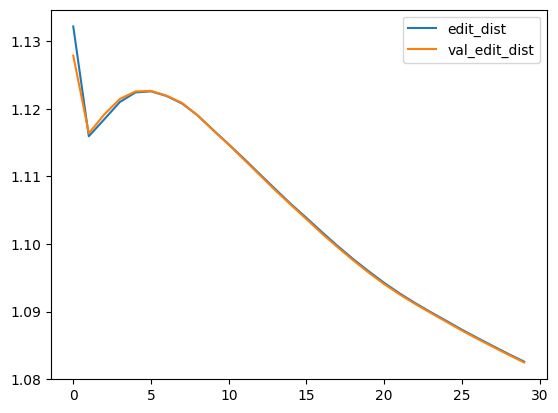

In [ ]:
plt.plot(history.history['edit_dist'])
plt.plot(history.history['val_edit_dist'])
plt.legend(['edit_dist', 'val_edit_dist'])

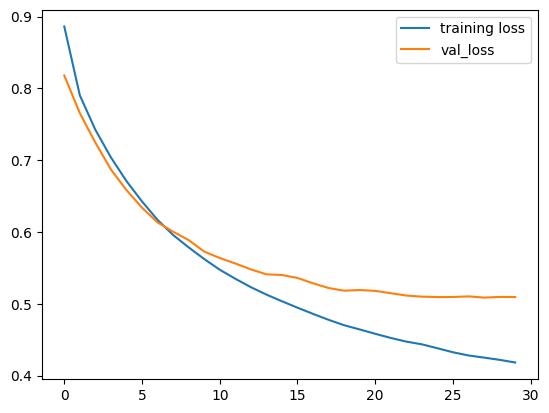

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])

In [ ]:
# class TFLiteModel(tf.Module):
#     def __init__(self, model):
#         super(TFLiteModel, self).__init__()
#         self.target_start_token_idx = start_token_idx
#         self.target_end_token_idx = end_token_idx
#         # Load the feature generation and main models
#         self.model = model
    
#     @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(FEATURE_COLUMNS)], dtype=tf.float32, name='inputs')])
#     def __call__(self, inputs, training=False):
#         # Preprocess Data
#         x = tf.cast(inputs, tf.float32)
#         x = x[None]
#         x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(FEATURE_COLUMNS))), lambda: tf.identity(x))
#         x = x[0]
#         x = pre_process(x)
#         x = x[None]
#         x = self.model.generate(x, self.target_start_token_idx)
#         x = x[0]
#         idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
#         idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
#         x = x[1:idx]
#         x = tf.one_hot(x, 59)
#         return {'outputs': x}
    
# tflitemodel_base = TFLiteModel(model)

In [ ]:
model.save_weights("model.h5")

In [ ]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()

# if not os.path.isdir("working"):
#     os.mkdir("working")
# else:
#     shutil.rmtree("working")
#     os.mkdir("working")

with open('./model.tflite', 'wb') as f:
    f.write(tflite_model)
    
infargs = {"selected_columns" : FEATURE_COLUMNS}

with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)

In [ ]:
!zip submission.zip  './model.tflite' './inference_args.json'

In [ ]:
interpreter = tf.lite.Interpreter("model.tflite")

REQUIRED_SIGNATURE = "serving_default"
REQUIRED_OUTPUT = "outputs"

with open ("./character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}

found_signatures = list(interpreter.get_signature_list().keys())

if REQUIRED_SIGNATURE not in found_signatures:
    raise KernelEvalException('Required input signature not found.')

prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=batch[0][0])
prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
print(prediction_str)